In [4]:
import os
import numpy as np
import pandas as pd
from skimage import io
import matplotlib.pyplot as plt
from glob import glob

from skimage.feature import graycomatrix, graycoprops
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC

In [5]:
def load_data_from_zip(zip_path):
    """
    Load chest X-ray images from a zip file, handling various directory structures.
    
    Parameters:
    -----------
    zip_path : str
        Path to the zip file containing image data
    
    Returns:
    --------
    images : list
        List of image arrays
    labels : list
        List of corresponding labels
    label_map : dict
        Dictionary mapping label indices to label names
    image_paths : list
        List of image file paths within the zip
    """
    import zipfile
    import os
    import numpy as np
    from skimage import io
    from io import BytesIO
    
    images = []
    labels = []
    image_paths = []
    
    # These are the expected class names based on your description
    expected_classes = ["COVID-19", "Normal", "Pneumonia"]
    
    # Open the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # Get all file names in the zip
        file_list = zip_ref.namelist()
        
        # Analyze the directory structure
        directories = {}
        for path in file_list:
            parts = path.split('/')
            # Skip empty parts or files directly in root
            if len(parts) > 1 and parts[0]:
                if parts[0] not in directories:
                    directories[parts[0]] = []
                if len(parts) > 2 and parts[1]:
                    directories[parts[0]].append(parts[1])
        
        # Identify if we have a nested structure or direct class folders
        class_folders = []
        prefix_path = ""
        
        # Check if any of the top directories are the expected classes
        top_level_matches = [d for d in directories.keys() if any(
            cls.lower() in d.lower() for cls in expected_classes)]
        
        if top_level_matches:
            # The classes are at the top level
            class_folders = sorted(list(set(directories.keys())))
            print(f"Found classes at the top level: {class_folders}")
        else:
            # Try to find the classes in subdirectories
            for top_dir, subdirs in directories.items():
                cleaned_subdirs = list(set([s for s in subdirs if s and not s.startswith('.')]))
                matches = [d for d in cleaned_subdirs if any(
                    cls.lower() in d.lower() for cls in expected_classes)]
                
                if matches:
                    class_folders = sorted(list(set(cleaned_subdirs)))
                    prefix_path = top_dir + "/"
                    print(f"Found classes in subdirectory '{top_dir}': {class_folders}")
                    break
        
        if not class_folders:
            raise ValueError("Could not identify class folders in the zip structure")
        
        # Create a label mapping
        label_map = {i: label for i, label in enumerate(class_folders)}
        
        # Loop through each class folder
        for label_idx, folder in enumerate(class_folders):
            print(f"Loading images from {folder}...")
            folder_path = f"{prefix_path}{folder}/"
            
            # Get all image files in this folder
            img_paths = [f for f in file_list if f.startswith(folder_path) and 
                        (f.lower().endswith('.png') or f.lower().endswith('.jpg') or 
                         f.lower().endswith('.jpeg')) and not '/.' in f]
            
            # Load each image
            loaded_count = 0
            for img_path in img_paths:
                try:
                    # Read image data from zip
                    with zip_ref.open(img_path) as file:
                        img_data = BytesIO(file.read())
                        img = io.imread(img_data)
                        
                        # Convert to grayscale if it's color
                        if len(img.shape) > 2:
                            img = np.mean(img, axis=2).astype(np.uint8)
                        
                        images.append(img)
                        labels.append(label_idx)
                        image_paths.append(img_path)
                        loaded_count += 1
                        
                except Exception as e:
                    print(f"Error loading {img_path}: {e}")
            
            print(f"Loaded {loaded_count} images from {folder}")
        
        print(f"Total loaded: {len(images)} images")
    
    return images, labels, label_map, image_paths

In [99]:
def extract_glcm_features_df(images,
                            labels,
                            image_paths, 
                            target_size=(512, 512),
                            properties=['contrast', 'homogeneity', 'energy', 'correlation'], 
                            distances=[1, 2,3], 
                            angles=[0, np.pi/4, np.pi/2, 3*np.pi/4],
                            g_levels=256):
    """
    Extract GLCM features from images and organize into a DataFrame with image IDs and labels.
    
    Parameters:
    -----------
    images : list
        List of image arrays
    labels : list
        List of corresponding labels
    image_paths : list
        List of image file paths or IDs
    target_size : tuple
        Size to resize all images to (width, height)
    properties : list
        List of GLCM properties to calculate (e.g., ['contrast', 'homogeneity'])
    distances : list
        List of distances for GLCM calculation
    angles : list
        List of angles for GLCM calculation
    g_levels : int
        Number of gray levels to use for GLCM calculation (default is 256)

    Returns:
    --------
    df : pandas DataFrame
        DataFrame containing image_id, label, and all GLCM features
    """
    import pandas as pd
    import numpy as np
    from skimage.feature import graycomatrix, graycoprops
    from skimage.transform import resize
    import os

    
    # Create feature labels
    feature_labels = []
    for prop in properties:
        for d in distances:
            for a in angles:
                angle_deg = int(a * 180 / np.pi)  # Convert angle to degrees
                feature_labels.append(f"{prop}_d{d}_a{angle_deg}")
    
    # Initialize feature array
    n_features = len(properties) * len(distances) * len(angles)
    features = np.zeros((len(images), n_features))
    
    # Create image IDs from paths (get filename without extension)
    if isinstance(image_paths[0], str):
        image_ids = [os.path.splitext(os.path.basename(path))[0] for path in image_paths]
    else:
        # If not paths, use as is
        image_ids = image_paths
    
    # Extract GLCM features for each image
    for i, img in enumerate(images):
        if i % 100 == 0:
            print(f"Processing image {i}/{len(images)}")
        
        # Resize image to ensure consistency
        img_resized = resize(img, target_size, anti_aliasing=True, preserve_range=True).astype(np.uint8)
        
        # Rescale the image to have values between 0 and (levels-1)
        levels = g_levels
        # Normalization: Min-max scaling to range [0, levels-1]
        img_scaled = ((img_resized - img_resized.min()) / (img_resized.max() - img_resized.min() + 1e-10) * (levels-1)).astype(np.uint8)
        
        # Calculate GLCM
        glcm = graycomatrix(img_scaled, distances=distances, angles=angles, 
                           levels=levels, symmetric=True, normed=True)
        
        # Calculate GLCM properties
        feature_idx = 0
        for prop in properties:
            glcm_prop = graycoprops(glcm, prop)
            for d in range(len(distances)):
                for a in range(len(angles)):
                    features[i, feature_idx] = glcm_prop[d, a]
                    feature_idx += 1
    
    # Create the DataFrame
    data = {
        'image_id': image_ids,
        'label': labels
    }
    
    # Add each feature as a column
    for i, feature_name in enumerate(feature_labels):
        data[feature_name] = features[:, i]
    
    # Create the DataFrame
    df = pd.DataFrame(data)
    
    return glcm, df

In [7]:
# originial image data
og_data_path = os.path.join(os.getcwd(), 'Xray_data.zip')
images, labels,label_map, image_paths = load_data_from_zip(og_data_path)

Found classes in subdirectory 'Xray_data': ['COVID-19 cases', 'Normal ', 'Pneumonia']
Loading images from COVID-19 cases...
Loaded 221 images from COVID-19 cases
Loading images from Normal ...
Loaded 234 images from Normal 
Loading images from Pneumonia...
Loaded 148 images from Pneumonia
Total loaded: 603 images


Extracted glcm features('contrast', 'homogeneity', 'energy', and 'correlation') using distances [1,5] and angles [0, pi/2] (aka above and lateral) from the unedited x ray images.

In [8]:
glcm, glcm_df = extract_glcm_features_df(
    images, 
    labels, 
    image_paths, 
    target_size=(512, 512),
    distances=[1,5],
    angles=[0, np.pi/2]
)

Processing image 0/603
Processing image 100/603
Processing image 200/603
Processing image 300/603
Processing image 400/603
Processing image 500/603
Processing image 600/603


In [9]:
glcm_df.head()

,image_id,label,contrast_d1_a0,contrast_d1_a90,contrast_d5_a0,contrast_d5_a90,homogeneity_d1_a0,homogeneity_d1_a90,homogeneity_d5_a0,homogeneity_d5_a90,energy_d1_a0,energy_d1_a90,energy_d5_a0,energy_d5_a90,correlation_d1_a0,correlation_d1_a90,correlation_d5_a0,correlation_d5_a90
0,radiopaedia-2019-novel-coronavirus-infected-pn...,0,24.453844,24.176630,226.847591,177.311637,0.370738,0.395188,0.217560,0.260809,0.096179,0.097185,0.084514,0.089820,0.997345,0.997376,0.975167,0.980610
1,9fdd3c3032296fd04d2cad5d9070d4_jumbo,0,11.199746,11.994970,88.008013,78.651620,0.419133,0.417754,0.233933,0.269378,0.044930,0.044160,0.034020,0.034414,0.997881,0.997723,0.983295,0.984810
2,16669_3_1,0,38.821379,28.421623,105.586666,120.031816,0.441676,0.460867,0.245330,0.242679,0.031590,0.032510,0.020713,0.020742,0.987164,0.990556,0.965078,0.959352
3,radiol.2020201160.fig6b,0,49.370096,31.732915,262.576950,248.636696,0.397068,0.431660,0.168192,0.216623,0.027371,0.028953,0.017167,0.018613,0.992311,0.995055,0.959290,0.961091
4,16663_1_1,0,23.052864,14.995031,265.784821,124.553809,0.363245,0.403813,0.158876,0.204399,0.040099,0.041171,0.032132,0.032723,0.996277,0.997577,0.956411,0.979611


In [10]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    glcm_df.drop(columns=['image_id', 'label'], axis=1),
                                                    glcm_df['label'],
                                                    test_size=0.3,
                                                    random_state=113,
                                                    stratify=glcm_df['label']
                                                    )

In [14]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

# Random Forest on unedited data

In [15]:
# Train a Random Forest Classifier on scaled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=113, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=113)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        66
           1       0.86      0.96      0.91        70
           2       0.85      0.78      0.81        45

    accuracy                           0.88       181
   macro avg       0.88      0.87      0.87       181
weighted avg       0.88      0.88      0.88       181


Confusion Matrix:


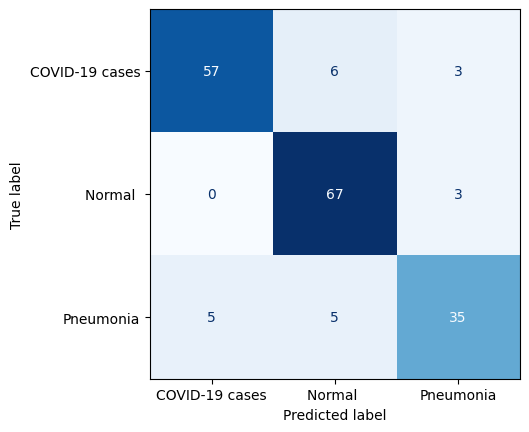

In [16]:
# Evaluate the model

y_pred = rf_model.predict(X_test)
    
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

# SVM on unedited data

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    SVC(kernel='rbf', random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Best parameters rbf: {grid_search.best_params_}")

Best parameters rbf: {'C': 100, 'gamma': 0.01}



Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.91      0.90        66
           1       0.92      0.84      0.88        70
           2       0.78      0.84      0.81        45

    accuracy                           0.87       181
   macro avg       0.86      0.87      0.86       181
weighted avg       0.87      0.87      0.87       181


Confusion Matrix:


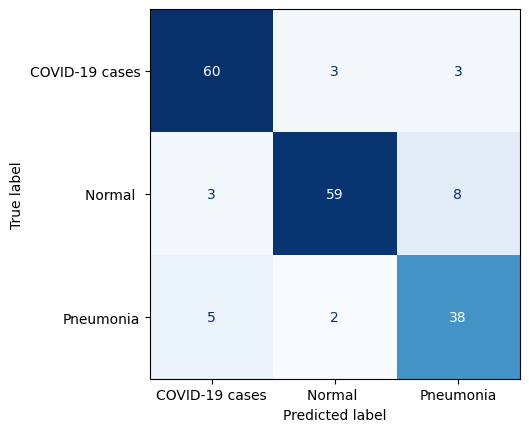

In [18]:
svm_rbf = SVC(kernel='rbf',
              C=100,
              gamma=0.01,
              class_weight='balanced',
              random_state=113
              )
svm_rbf.fit(X_train, y_train)

           
# Evaluate
y_pred = svm_rbf.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()


In [20]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1]
}

grid_search = GridSearchCV(
    SVC(kernel='linear', random_state=42),
    param_grid,
    cv=5,
    scoring='balanced_accuracy',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print(f"Best parameters linear: {grid_search.best_params_}")

Best parameters linear: {'C': 100, 'gamma': 'scale'}



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        66
           1       0.88      0.80      0.84        70
           2       0.75      0.84      0.79        45

    accuracy                           0.85       181
   macro avg       0.84      0.85      0.85       181
weighted avg       0.86      0.85      0.85       181


Confusion Matrix:


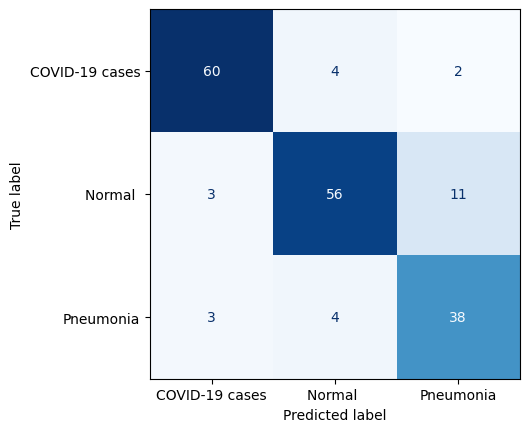

In [21]:
svm_linear = SVC(kernel='linear',
                 C=100,
                 gamma='scale',
                class_weight='balanced',
                random_state=113
                )
svm_linear.fit(X_train, y_train)

y_pred = svm_linear.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)

# Cleaned Data

In [22]:
# cleaned image data
cleaned_path = os.path.join(os.getcwd(), 'cleaned.zip')
images, labels, label_map, image_paths = load_data_from_zip(cleaned_path)

Found classes in subdirectory 'cleaned': ['COVID-19', 'Normal', 'Pneumonia']
Loading images from COVID-19...
Loaded 221 images from COVID-19
Loading images from Normal...
Loaded 234 images from Normal
Loading images from Pneumonia...
Loaded 148 images from Pneumonia
Total loaded: 603 images


In [61]:
cl_glcm, cl_glcm_df = extract_glcm_features_df(
    images, 
    labels, 
    image_paths, 
    target_size=(512, 512),
    distances=[1,5,10],
    angles=[0, np.pi/4,np.pi/2, 3*np.pi/4]
)

Processing image 0/603
Processing image 100/603
Processing image 200/603
Processing image 300/603
Processing image 400/603
Processing image 500/603
Processing image 600/603


In [81]:
cl_glcm_df.head()


,image_id,label,contrast_d1_a0,contrast_d1_a45,contrast_d1_a90,contrast_d1_a135,contrast_d5_a0,contrast_d5_a45,contrast_d5_a90,contrast_d5_a135,...,correlation_d1_a90,correlation_d1_a135,correlation_d5_a0,correlation_d5_a45,correlation_d5_a90,correlation_d5_a135,correlation_d10_a0,correlation_d10_a45,correlation_d10_a90,correlation_d10_a135
0,01E392EE-69F9-4E33-BFCE-E5C968654078,0,27.577162,34.367676,8.150914,35.263537,107.607965,140.377902,85.564519,150.032306,...,0.998589,0.993886,0.981234,0.975535,0.985164,0.973852,0.968469,0.960020,0.962608,0.956304
1,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C,0,8.900150,17.888810,10.944078,18.394625,92.654420,115.271146,99.588750,116.940061,...,0.997832,0.996356,0.981721,0.976849,0.979903,0.976515,0.956295,0.954334,0.955105,0.954337
2,1-s2.0-S0140673620303706-fx1_lrg,0,129.687038,177.743839,116.025291,175.584380,364.664259,363.797151,246.488073,360.621935,...,0.957428,0.935495,0.867012,0.866397,0.909406,0.867560,0.776911,0.807379,0.874307,0.807388
3,1-s2.0-S0929664620300449-gr2_lrg-a,0,15.888114,25.079182,14.382644,27.702318,140.179206,138.771169,101.700856,158.145801,...,0.998676,0.997445,0.986987,0.987056,0.990573,0.985248,0.963705,0.972539,0.978453,0.968233
4,1-s2.0-S0929664620300449-gr2_lrg-b,0,88.416941,95.797894,13.714836,97.169397,222.857614,221.823784,80.584115,231.687391,...,0.998086,0.986362,0.968659,0.968584,0.988656,0.967187,0.947481,0.954905,0.977372,0.952518


In [62]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    cl_glcm_df.drop(columns=['image_id', 'label'], axis=1),
                                                    cl_glcm_df['label'],
                                                    test_size=0.3,
                                                    random_state=113,
                                                    stratify=cl_glcm_df['label']
                                                    )

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest on Cleaned Data

In [63]:
# Train a Random Forest Classifier on scaled cleaned data
rf_model = RandomForestClassifier(n_estimators=100, random_state=113, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=113)


Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.86      0.86        66
           1       0.84      0.89      0.86        70
           2       0.78      0.69      0.73        45

    accuracy                           0.83       181
   macro avg       0.82      0.81      0.82       181
weighted avg       0.83      0.83      0.83       181


Confusion Matrix:


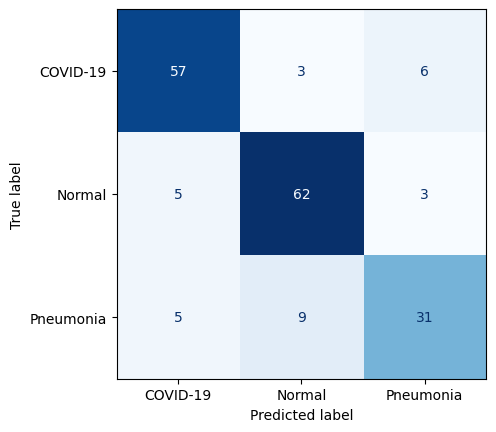

In [64]:
# Evaluate the model

y_pred = rf_model.predict(X_test)
    
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

# SVM on Edited Data

In [ ]:
param_grid = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7),
    'degree': [2, 3, 4]
}

svm_gridsearch = GridSearchCV(
    SVC(probability=True),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)


svm_gridsearch.fit(X= X_train, y= y_train)

Fitting 5 folds for each of 588 candidates, totalling 2940 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'degree': [2, 3, 4],
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1_macro', verbose=1)

In [74]:
best_params = svm_gridsearch.best_params_
print(f"Best parameters: {best_params}")
best_svm = SVC(**best_params)

Best parameters: {'C': np.float64(1000.0), 'degree': 2, 'gamma': np.float64(0.001), 'kernel': 'rbf'}



Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94        66
           1       0.90      0.89      0.89        70
           2       0.84      0.82      0.83        45

    accuracy                           0.90       181
   macro avg       0.89      0.89      0.89       181
weighted avg       0.89      0.90      0.89       181


Confusion Matrix:


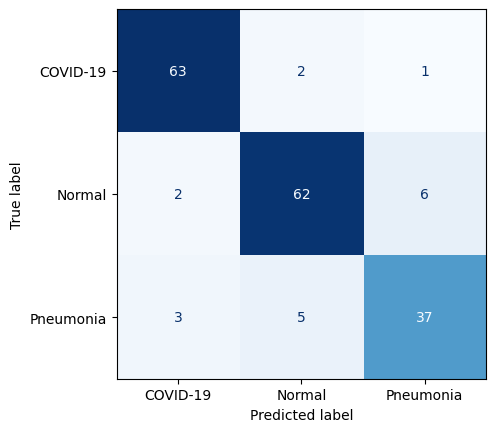

In [75]:
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

In [ ]:
# Finer grid search around best values
fine_param_grid = {
    'C': np.logspace(2, 4, 10),  # Values between 100 and 10000
    'gamma': np.logspace(-4, -2, 10),  # Values around 0.001
    'kernel': ['rbf'],
    'class_weight': [None, 'balanced']  # Try with class weighting
}

fine_svm_gridsearch = GridSearchCV(
    SVC(probability=True),
    fine_param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)

fine_svm_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': array([  100.        ,   166.81005372,   278.25594022,   464.15888336,
         774.26368268,  1291.54966501,  2154.43469003,  3593.8136638 ,
        5994.84250319, 10000.        ]),
                         'class_weight': [None, 'balanced'],
                         'gamma': array([0.0001    , 0.00016681, 0.00027826, 0.00046416, 0.00077426,
       0.00129155, 0.00215443, 0.00359381, 0.00599484, 0.01      ]),
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

In [77]:
best_params = fine_svm_gridsearch.best_params_
print(f"Best parameters: {best_params}")
best_svm = SVC(**best_params)

Best parameters: {'C': np.float64(10000.0), 'class_weight': 'balanced', 'gamma': np.float64(0.0002782559402207126), 'kernel': 'rbf'}



Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        66
           1       0.95      0.87      0.91        70
           2       0.83      0.87      0.85        45

    accuracy                           0.91       181
   macro avg       0.90      0.90      0.90       181
weighted avg       0.91      0.91      0.91       181


Confusion Matrix:


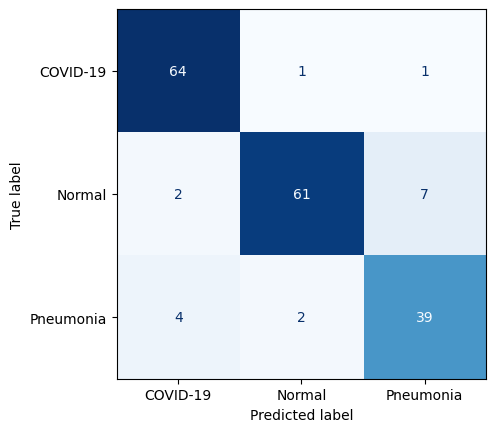

In [78]:
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

# Permuation Feauture Importance on Best SVM model

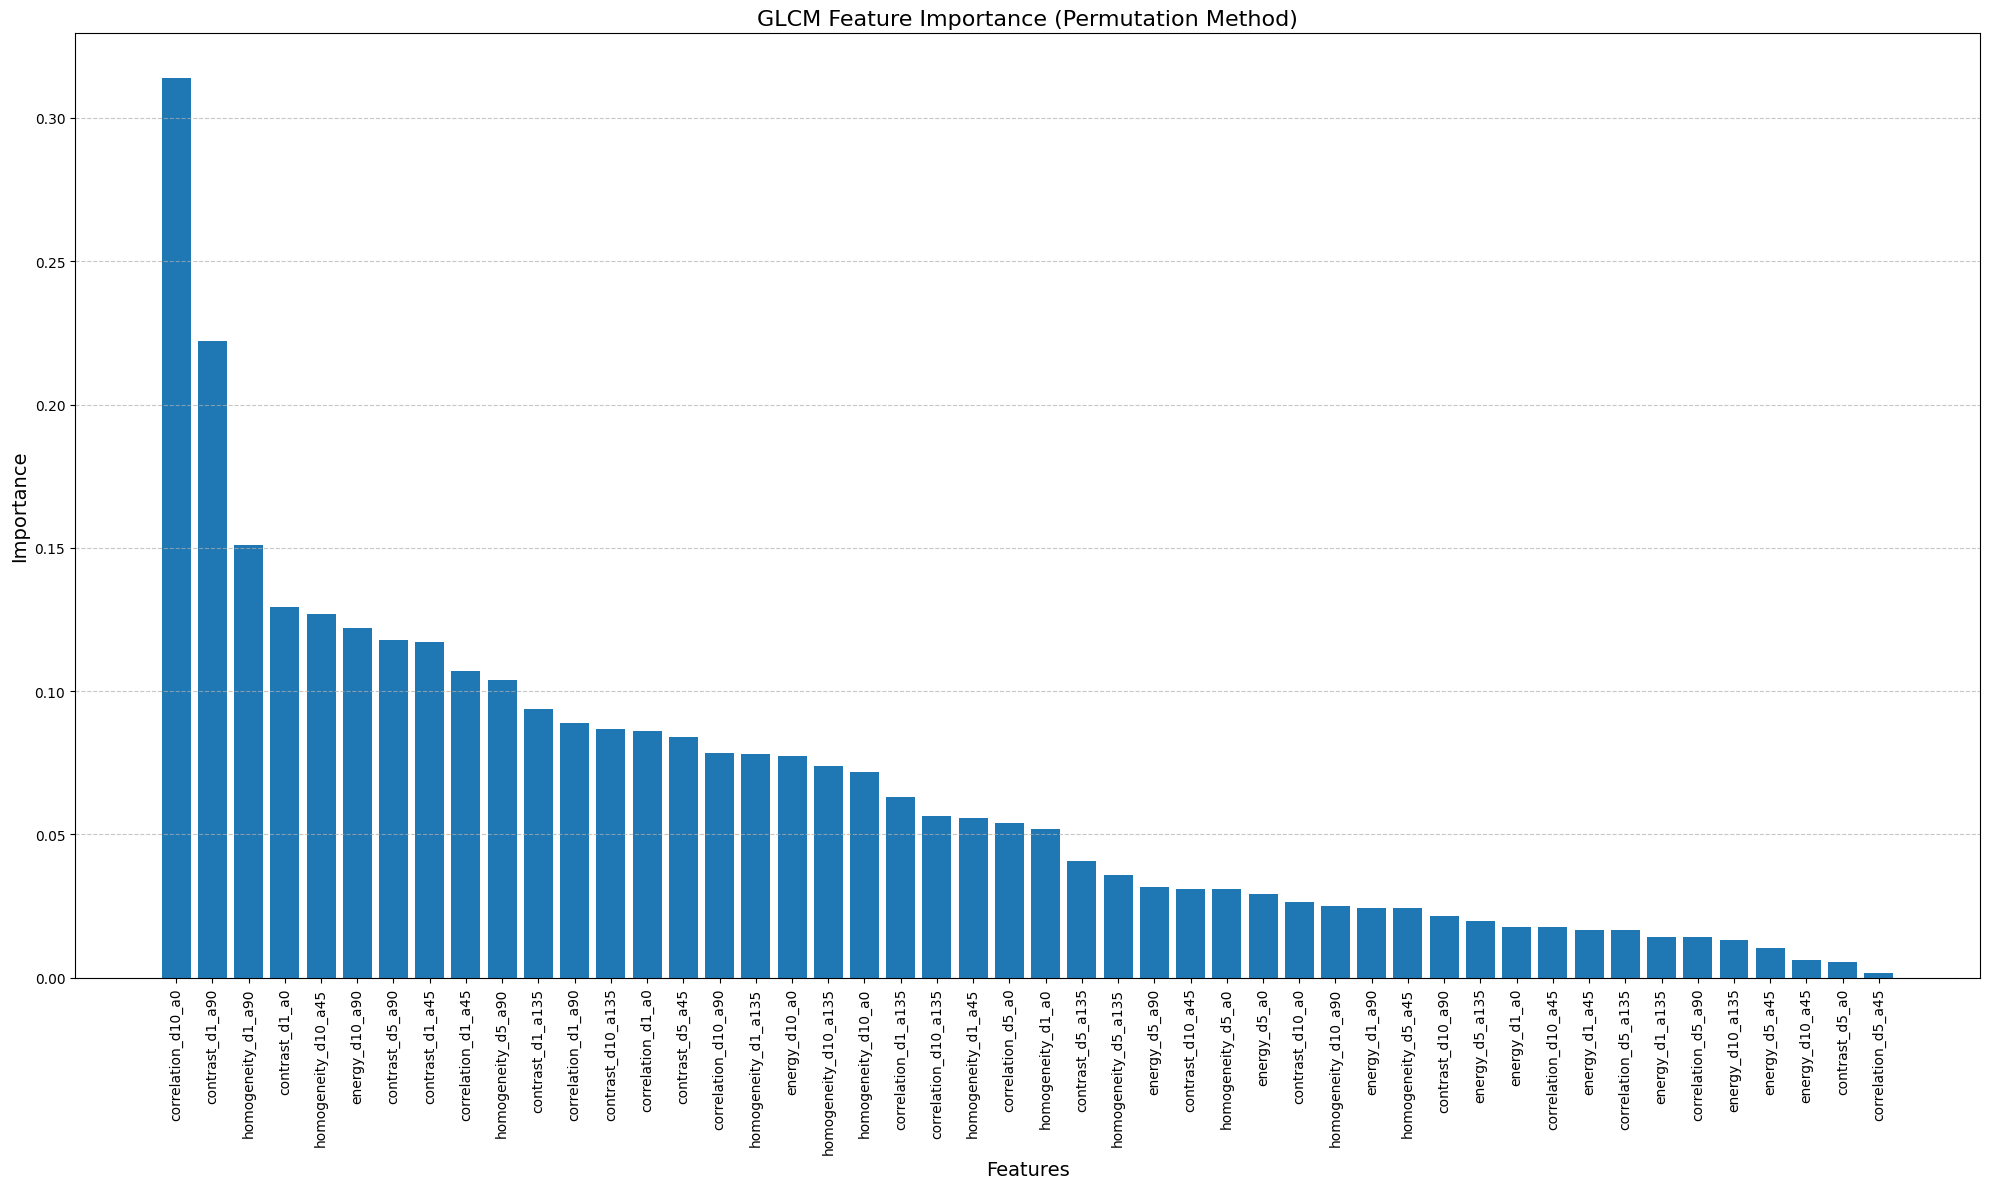

In [96]:

from sklearn.inspection import permutation_importance

# best model
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Extract feature names from df
feature_names = cl_glcm_df.drop(columns=['image_id', 'label']).columns.tolist()

# Calculate permutation importance
result = permutation_importance(best_svm, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = result.importances_mean

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# Plot ALL features
plt.figure(figsize=(20, 12))  # Larger figure for 48 features
plt.title("GLCM Feature Importance (Permutation Method)", fontsize=16)
plt.bar(range(len(perm_importances)), perm_importances[perm_indices], align="center")
plt.xticks(range(len(perm_importances)), [feature_names[i] for i in perm_indices], rotation=90, fontsize=10)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [97]:
# Print ALL features with their importance values
print("All features by importance:")
for i in range(len(perm_importances)):
    print(f"{feature_names[perm_indices[i]]}: {perm_importances[perm_indices[i]]:.6f}")

All features by importance:
correlation_d10_a0: 0.313812
contrast_d1_a90: 0.222099
homogeneity_d1_a90: 0.150829
contrast_d1_a0: 0.129282
homogeneity_d10_a45: 0.127072
energy_d10_a90: 0.122099
contrast_d5_a90: 0.117680
contrast_d1_a45: 0.117127
correlation_d1_a45: 0.107182
homogeneity_d5_a90: 0.103867
contrast_d1_a135: 0.093923
correlation_d1_a90: 0.088950
contrast_d10_a135: 0.086740
correlation_d1_a0: 0.086188
contrast_d5_a45: 0.083978
correlation_d10_a90: 0.078453
homogeneity_d1_a135: 0.077901
energy_d10_a0: 0.077348
homogeneity_d10_a135: 0.074033
homogeneity_d10_a0: 0.071823
correlation_d1_a135: 0.062983
correlation_d10_a135: 0.056354
homogeneity_d1_a45: 0.055801
correlation_d5_a0: 0.054144
homogeneity_d1_a0: 0.051934
contrast_d5_a135: 0.040884
homogeneity_d5_a135: 0.035912
energy_d5_a90: 0.031492
contrast_d10_a45: 0.030939
homogeneity_d5_a0: 0.030939
energy_d5_a0: 0.029282
contrast_d10_a0: 0.026519
homogeneity_d10_a90: 0.024862
energy_d1_a90: 0.024309
homogeneity_d5_a45: 0.024309
co

# Trying different GLCM props based on feature importance

In [145]:
glcm, glcm_df = extract_glcm_features_df(
    images, 
    labels, 
    image_paths, 
    target_size=(512, 512),
    properties=['contrast', 'homogeneity', 'correlation', 'energy'],
    distances=[1, 3, 10, 15],
    angles=[0, np.pi/4,np.pi/2, 3*np.pi/4]
)

Processing image 0/603
Processing image 100/603
Processing image 200/603
Processing image 300/603
Processing image 400/603
Processing image 500/603
Processing image 600/603


In [146]:
glcm_df.head()

,image_id,label,contrast_d1_a0,contrast_d1_a45,contrast_d1_a90,contrast_d1_a135,contrast_d3_a0,contrast_d3_a45,contrast_d3_a90,contrast_d3_a135,...,energy_d3_a90,energy_d3_a135,energy_d10_a0,energy_d10_a45,energy_d10_a90,energy_d10_a135,energy_d15_a0,energy_d15_a45,energy_d15_a90,energy_d15_a135
0,01E392EE-69F9-4E33-BFCE-E5C968654078,0,27.577162,34.367676,8.150914,35.263537,86.558283,86.801726,41.891780,89.894483,...,0.052419,0.052470,0.044598,0.040654,0.040401,0.041918,0.041545,0.035735,0.035613,0.037666
1,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C,0,8.900150,17.888810,10.944078,18.394625,47.109809,48.344441,54.229805,49.608843,...,0.032988,0.032223,0.024311,0.024254,0.025333,0.024458,0.022167,0.021676,0.022746,0.021833
2,1-s2.0-S0140673620303706-fx1_lrg,0,129.687038,177.743839,116.025291,175.584380,259.446989,245.678301,206.058406,244.269070,...,0.018469,0.017428,0.013172,0.014088,0.016356,0.014130,0.012124,0.012829,0.015409,0.012805
3,1-s2.0-S0929664620300449-gr2_lrg-a,0,15.888114,25.079182,14.382644,27.702318,70.174776,59.854506,57.940113,66.825690,...,0.041878,0.039211,0.030176,0.030516,0.032336,0.029574,0.026820,0.026341,0.028988,0.025576
4,1-s2.0-S0929664620300449-gr2_lrg-b,0,88.416941,95.797894,13.714836,97.169397,175.461014,167.759493,48.108845,171.875817,...,0.101048,0.099876,0.090393,0.086395,0.090888,0.087128,0.084355,0.076758,0.083650,0.078000


In [147]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    glcm_df.drop(columns=['image_id', 'label'], axis=1),
                                                    glcm_df['label'],
                                                    test_size=0.3,
                                                    random_state=113,
                                                    stratify=glcm_df['label']
                                                    )

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87        66
           1       0.85      0.86      0.85        70
           2       0.77      0.73      0.75        45

    accuracy                           0.83       181
   macro avg       0.83      0.82      0.82       181
weighted avg       0.83      0.83      0.83       181


Confusion Matrix:


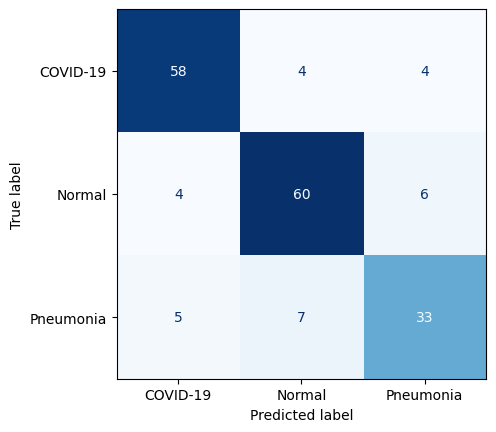

In [148]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=113, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
    
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
    

print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

In [ ]:
param_grid = {
    'kernel': ['rbf'],
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7)
}

svm_gridsearch = GridSearchCV(
    SVC(probability=True),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)


svm_gridsearch.fit(X= X_train, y= y_train)

Fitting 5 folds for each of 147 candidates, totalling 735 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'degree': [2, 3, 4],
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

Best parameters: {'C': np.float64(1000.0), 'degree': 2, 'gamma': np.float64(0.001), 'kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        66
           1       0.90      0.89      0.89        70
           2       0.83      0.78      0.80        45

    accuracy                           0.89       181
   macro avg       0.88      0.88      0.88       181
weighted avg       0.89      0.89      0.89       181


Confusion Matrix:


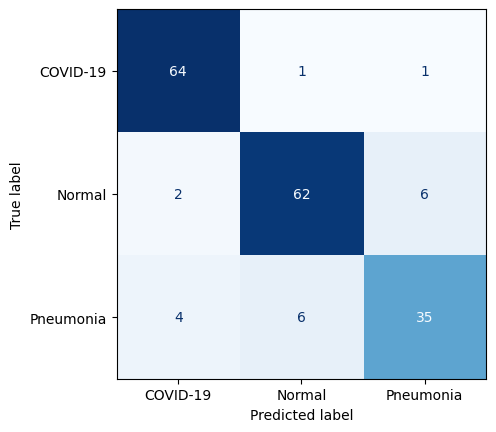

In [152]:
# 
best_params = svm_gridsearch.best_params_
print(f"Best parameters: {best_params}")
best_svm = SVC(**best_params)

best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

In [153]:
param_grid_alternative = {
    'kernel': ['rbf'],
    # Try higher C values to reduce misclassification
    'C': [1000, 1500, 2000, 3000, 5000, 7000],
    # Try slightly higher gamma values for better fitting to the Pneumonia class
    'gamma': [0.01, 0.015, 0.02, 0.025, 0.03],
    # Try more aggressive class weighting for the pneumonia class
    'class_weight': ['balanced', {0:1, 1:1, 2:1.75}, {0:1, 1:1, 2:2}],
    # Test probability calibration
    'probability': [True]
}

svm_gridsearch_alternative = GridSearchCV(
    SVC(),
    param_grid_alternative,
    cv=5,
    # Consider a custom scoring metric that emphasizes recall for pneumonia
    scoring='recall_macro',  # Try this instead of f1_macro
    n_jobs=-1,
    verbose=1
)

svm_gridsearch_alternative.fit(X_train, y_train)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1000, 1500, 2000, 3000, 5000, 7000],
                         'class_weight': ['balanced', {0: 1, 1: 1, 2: 1.75},
                                          {0: 1, 1: 1, 2: 2}],
                         'gamma': [0.01, 0.015, 0.02, 0.025, 0.03],
                         'kernel': ['rbf'], 'probability': [True]},
             scoring='recall_macro', verbose=1)

Best parameters: {'C': 1000, 'class_weight': 'balanced', 'gamma': 0.01, 'kernel': 'rbf', 'probability': True}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.94      0.93        66
           1       0.86      0.84      0.85        70
           2       0.77      0.76      0.76        45

    accuracy                           0.86       181
   macro avg       0.85      0.85      0.85       181
weighted avg       0.86      0.86      0.86       181


Confusion Matrix:


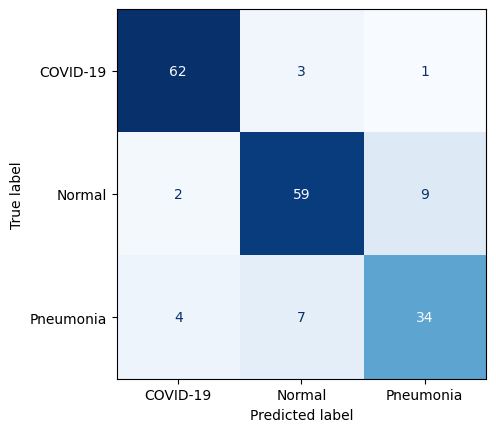

In [154]:
best_params = svm_gridsearch_alternative.best_params_
print(f"Best parameters: {best_params}")
best_svm = SVC(**best_params)

best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

Best parameters: {'C': np.float64(1000.0), 'degree': 2, 'gamma': np.float64(0.001), 'kernel': 'rbf'}


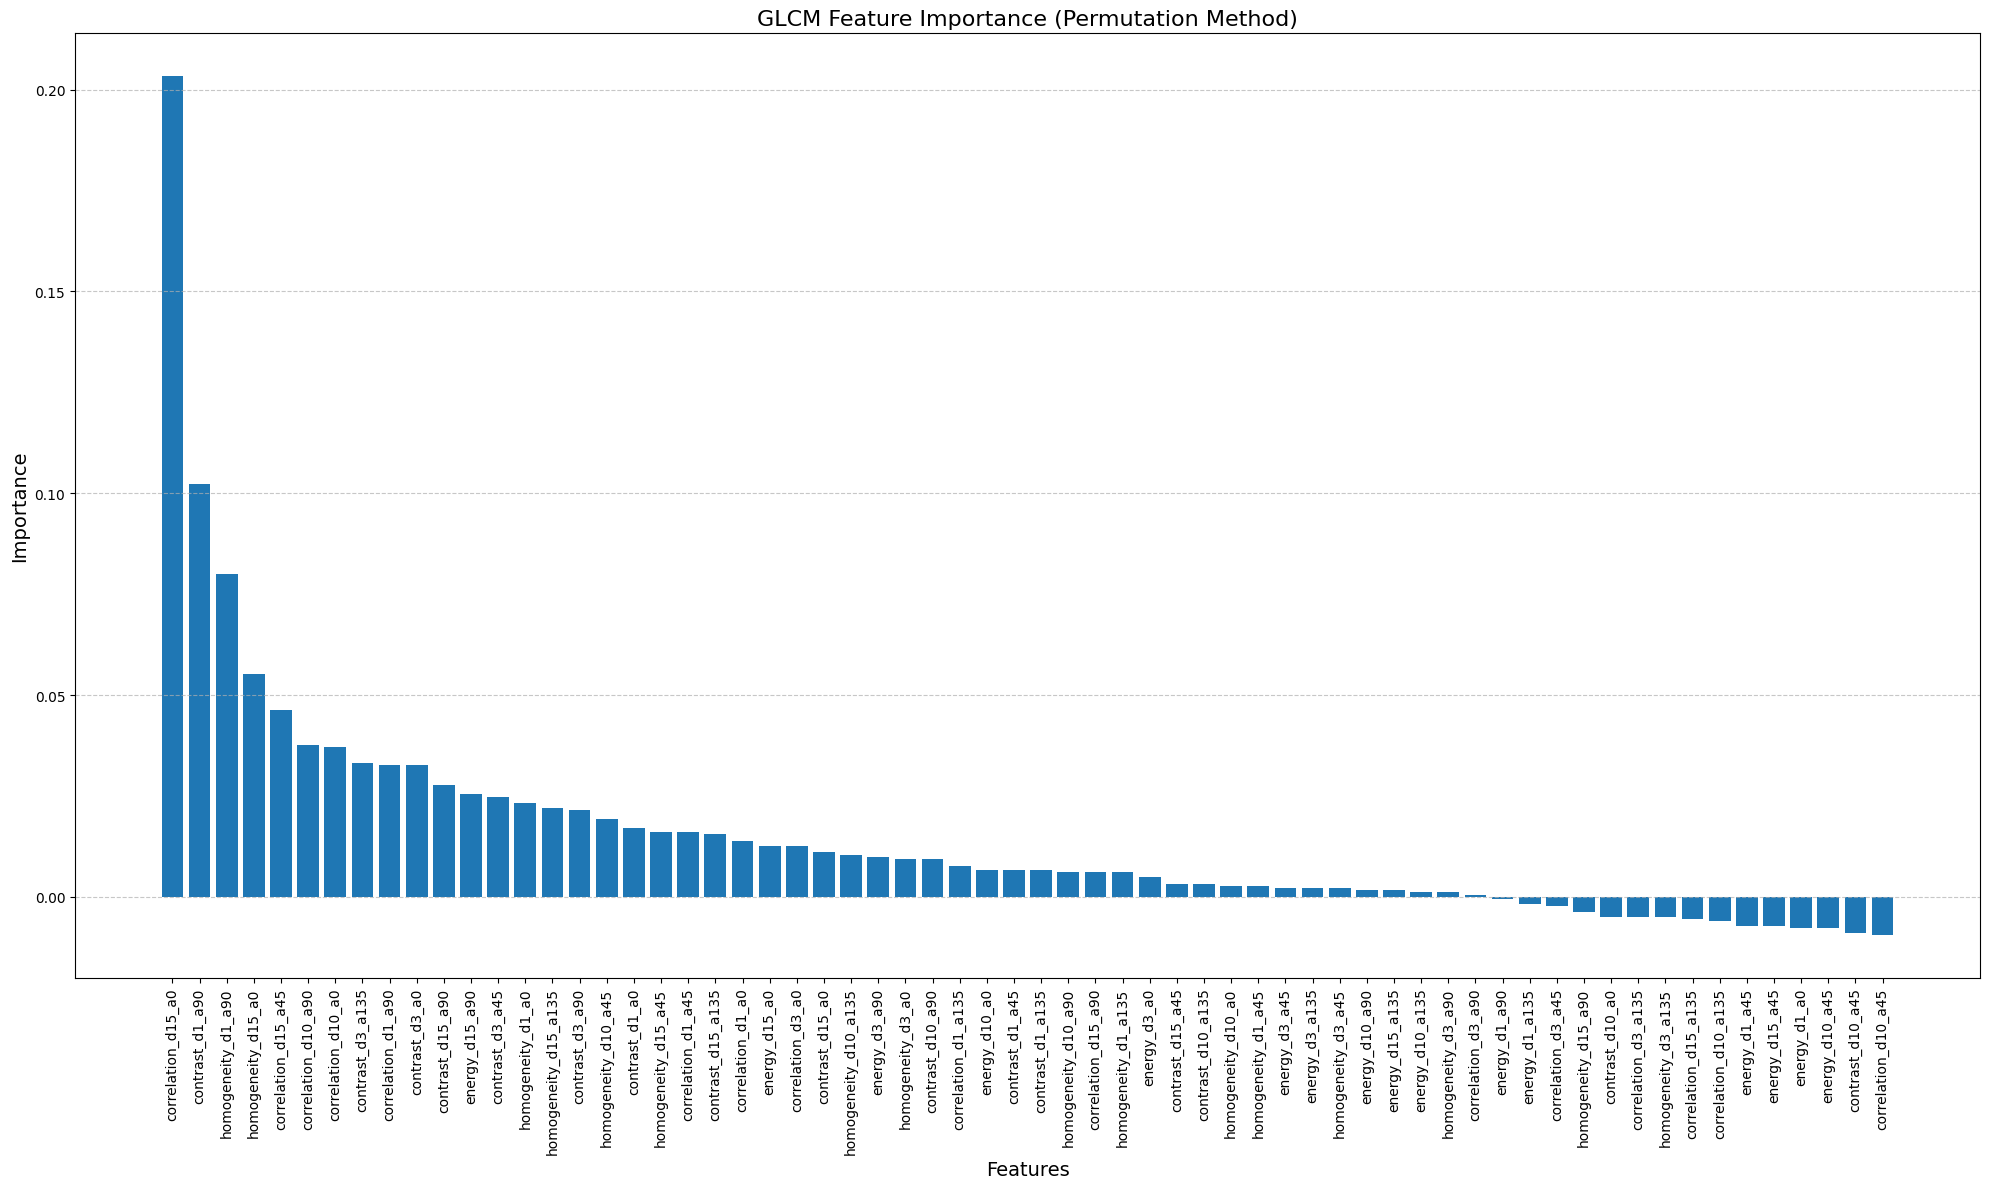

In [155]:

from sklearn.inspection import permutation_importance

# best model
best_params = svm_gridsearch.best_params_
print(f"Best parameters: {best_params}")
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Extract feature names from df
feature_names = glcm_df.drop(columns=['image_id', 'label']).columns.tolist()

# Calculate permutation importance
result = permutation_importance(best_svm, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = result.importances_mean

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# Plot ALL features
plt.figure(figsize=(20, 12))  # Larger figure for 48 features
plt.title("GLCM Feature Importance (Permutation Method)", fontsize=16)
plt.bar(range(len(perm_importances)), perm_importances[perm_indices], align="center")
plt.xticks(range(len(perm_importances)), [feature_names[i] for i in perm_indices], rotation=90, fontsize=10)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Print features with their importance values
print("All features by importance:")
for i in range(len(perm_importances)):
    print(f"{feature_names[perm_indices[i]]}: {perm_importances[perm_indices[i]]:.6f}")

All features by importance:
correlation_d15_a0: 0.203315
contrast_d1_a90: 0.102210
homogeneity_d1_a90: 0.080110
homogeneity_d15_a0: 0.055249
correlation_d15_a45: 0.046409
correlation_d10_a90: 0.037569
correlation_d10_a0: 0.037017
contrast_d3_a135: 0.033149
correlation_d1_a90: 0.032597
contrast_d3_a0: 0.032597
contrast_d15_a90: 0.027624
energy_d15_a90: 0.025414
contrast_d3_a45: 0.024862
homogeneity_d1_a0: 0.023204
homogeneity_d15_a135: 0.022099
contrast_d3_a90: 0.021547
homogeneity_d10_a45: 0.019337
contrast_d1_a0: 0.017127
homogeneity_d15_a45: 0.016022
correlation_d1_a45: 0.016022
contrast_d15_a135: 0.015470
correlation_d1_a0: 0.013812
energy_d15_a0: 0.012707
correlation_d3_a0: 0.012707
contrast_d15_a0: 0.011050
homogeneity_d10_a135: 0.010497
energy_d3_a90: 0.009945
homogeneity_d3_a0: 0.009392
contrast_d10_a90: 0.009392
correlation_d1_a135: 0.007735
energy_d10_a0: 0.006630
contrast_d1_a45: 0.006630
contrast_d1_a135: 0.006630
homogeneity_d10_a90: 0.006077
correlation_d15_a90: 0.006077
h

In [ ]:
# identify features to drop based on negative importance
drop_feats = [feature_names[i] for i, importance in enumerate(perm_importances) if importance < 0]
print(f"Features to drop: {drop_feats}")

Features to drop: ['contrast_d10_a0', 'contrast_d10_a45', 'homogeneity_d3_a135', 'homogeneity_d15_a90', 'correlation_d3_a45', 'correlation_d3_a135', 'correlation_d10_a45', 'correlation_d10_a135', 'correlation_d15_a135', 'energy_d1_a0', 'energy_d1_a45', 'energy_d1_a90', 'energy_d1_a135', 'energy_d10_a45', 'energy_d15_a45']


In [158]:
drop_df = glcm_df.drop(columns=drop_feats, axis=1)
X_train, X_test, y_train, y_test = train_test_split(
                                                    drop_df.drop(columns=['image_id', 'label'], axis=1),
                                                    drop_df['label'],
                                                    test_size=0.3,
                                                    random_state=113,
                                                    stratify=drop_df['label']
                                                    )
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

drop_df.head()

,image_id,label,contrast_d1_a0,contrast_d1_a45,contrast_d1_a90,contrast_d1_a135,contrast_d3_a0,contrast_d3_a45,contrast_d3_a90,contrast_d3_a135,...,energy_d3_a0,energy_d3_a45,energy_d3_a90,energy_d3_a135,energy_d10_a0,energy_d10_a90,energy_d10_a135,energy_d15_a0,energy_d15_a90,energy_d15_a135
0,01E392EE-69F9-4E33-BFCE-E5C968654078,0,27.577162,34.367676,8.150914,35.263537,86.558283,86.801726,41.891780,89.894483,...,0.053579,0.052331,0.052419,0.052470,0.044598,0.040401,0.041918,0.041545,0.035613,0.037666
1,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C,0,8.900150,17.888810,10.944078,18.394625,47.109809,48.344441,54.229805,49.608843,...,0.031861,0.032076,0.032988,0.032223,0.024311,0.025333,0.024458,0.022167,0.022746,0.021833
2,1-s2.0-S0140673620303706-fx1_lrg,0,129.687038,177.743839,116.025291,175.584380,259.446989,245.678301,206.058406,244.269070,...,0.016658,0.017392,0.018469,0.017428,0.013172,0.016356,0.014130,0.012124,0.015409,0.012805
3,1-s2.0-S0929664620300449-gr2_lrg-a,0,15.888114,25.079182,14.382644,27.702318,70.174776,59.854506,57.940113,66.825690,...,0.039419,0.040213,0.041878,0.039211,0.030176,0.032336,0.029574,0.026820,0.028988,0.025576
4,1-s2.0-S0929664620300449-gr2_lrg-b,0,88.416941,95.797894,13.714836,97.169397,175.461014,167.759493,48.108845,171.875817,...,0.100371,0.099742,0.101048,0.099876,0.090393,0.090888,0.087128,0.084355,0.083650,0.078000


# SVM w/o unimportant features

In [167]:
param_grid = {
    'kernel': [ 'rbf'],
    'C': np.logspace(-3, 3, 7),
    'gamma': np.logspace(-3, 3, 7)
}

svm_gridsearch = GridSearchCV(
    SVC(probability=True),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)


svm_gridsearch.fit(X= X_train, y= y_train)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'kernel': ['rbf']},
             scoring='f1_macro', verbose=1)

Best parameters: {'C': np.float64(1000.0), 'gamma': np.float64(0.001), 'kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        66
           1       0.91      0.89      0.90        70
           2       0.84      0.80      0.82        45

    accuracy                           0.90       181
   macro avg       0.89      0.89      0.89       181
weighted avg       0.89      0.90      0.89       181


Confusion Matrix:


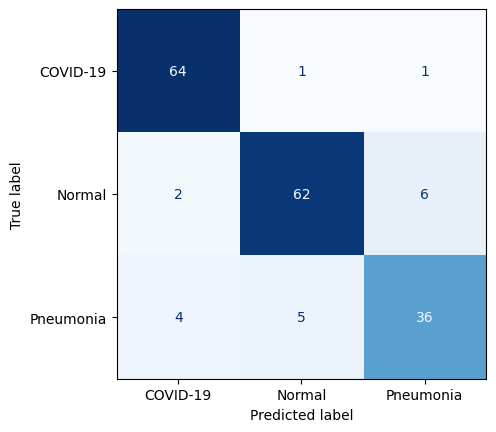

In [168]:
best_params = svm_gridsearch.best_params_
print(f"Best parameters: {best_params}")
best_svm = SVC(**best_params)

best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

Best parameters: {'C': np.float64(1000.0), 'gamma': np.float64(0.001), 'kernel': 'rbf'}


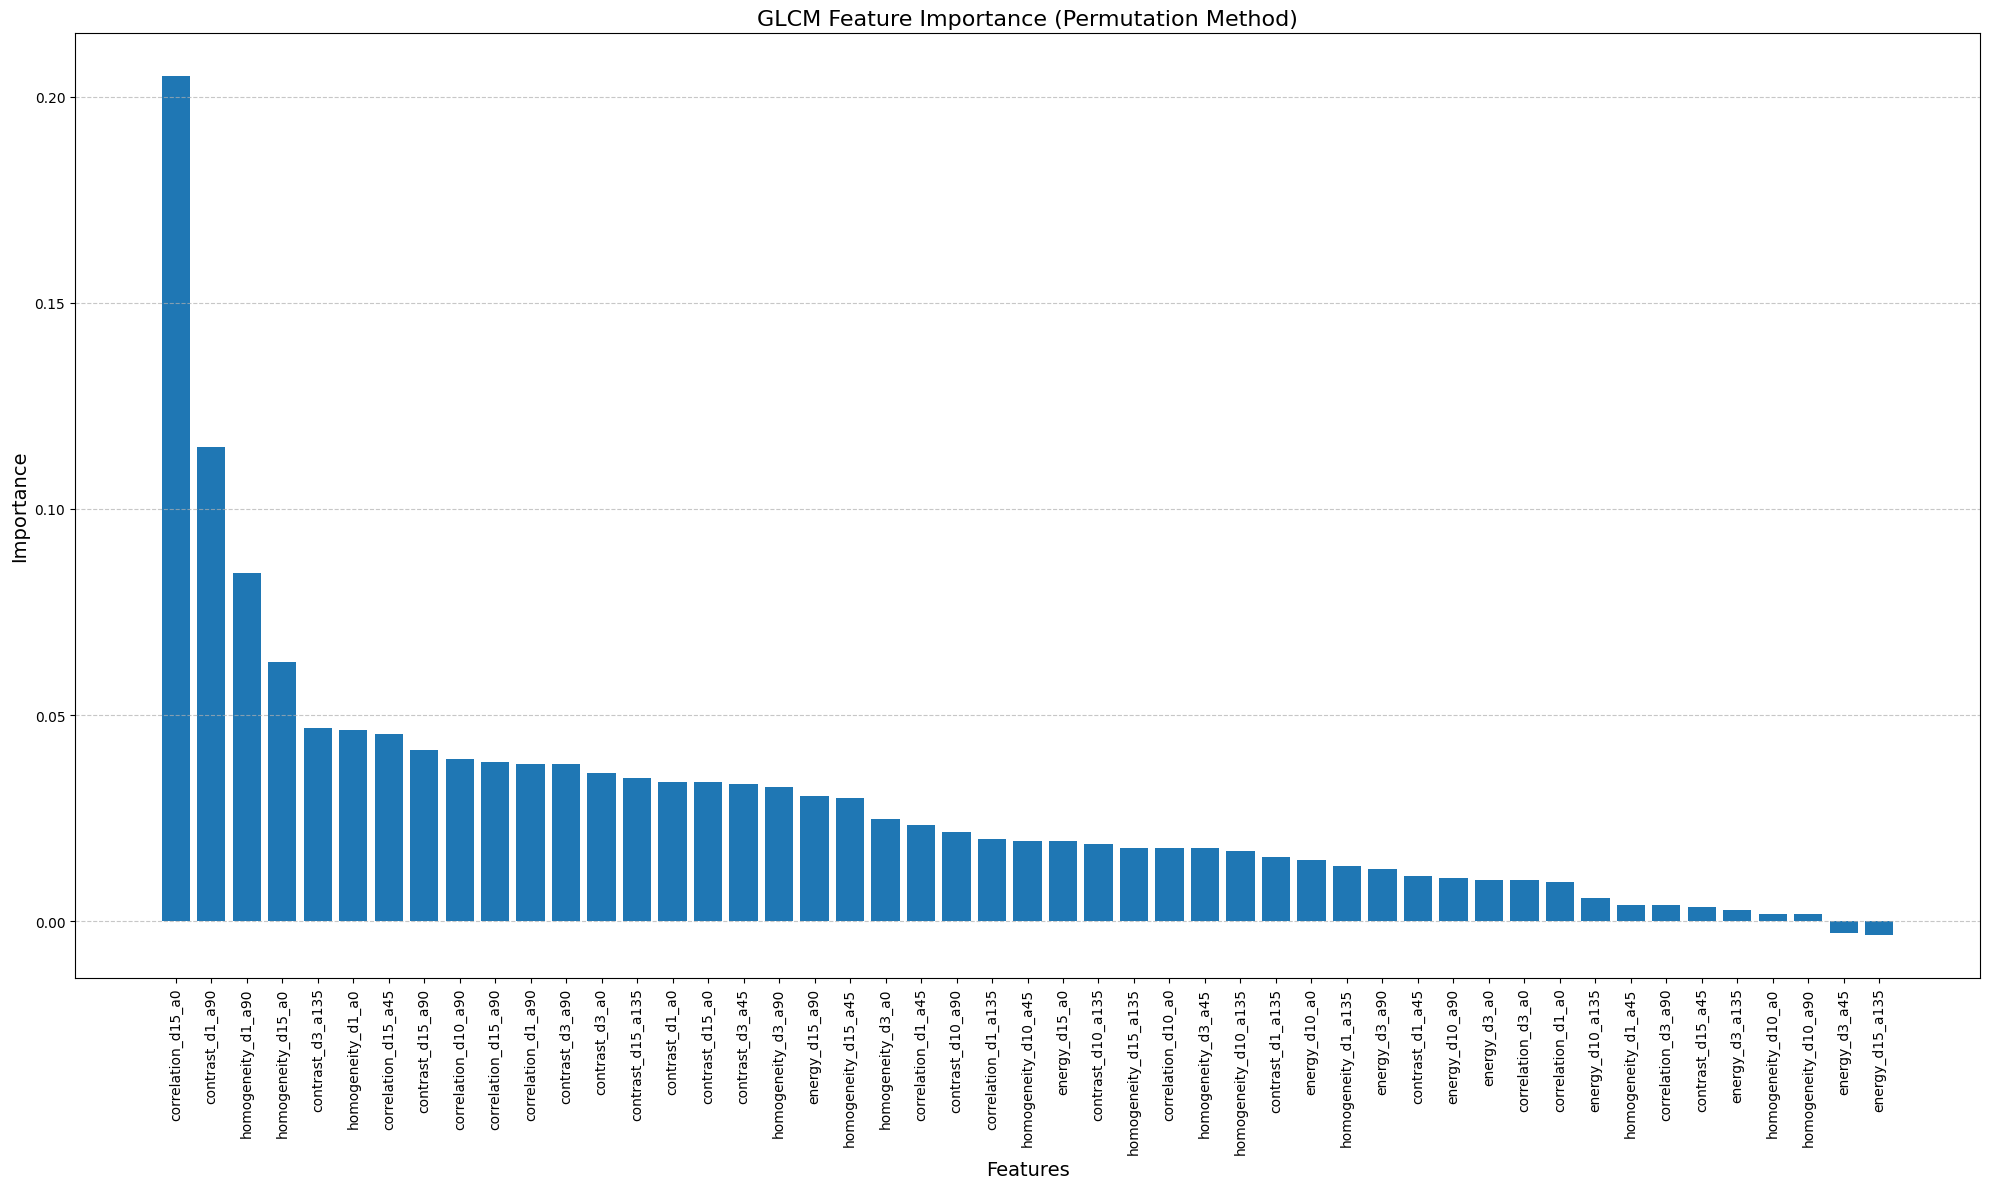

In [169]:
# best model
best_params = svm_gridsearch.best_params_
print(f"Best parameters: {best_params}")
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)

# Extract feature names from df
feature_names = drop_df.drop(columns=['image_id', 'label']).columns.tolist()

# Calculate permutation importance
result = permutation_importance(best_svm, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = result.importances_mean

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# Plot ALL features
plt.figure(figsize=(20, 12))  # Larger figure for 48 features
plt.title("GLCM Feature Importance (Permutation Method)", fontsize=16)
plt.bar(range(len(perm_importances)), perm_importances[perm_indices], align="center")
plt.xticks(range(len(perm_importances)), [feature_names[i] for i in perm_indices], rotation=90, fontsize=10)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [170]:
def correlation_dataframe(df):
    # Calculate correlation matrix
    corr_matrix = df.corr()
    
    # Initialize lists to store the data
    feature1_list = []
    feature2_list = []
    correlation_list = []
    
    # Iterate through the correlation matrix
    for i, feature1 in enumerate(corr_matrix.columns):
        for j, feature2 in enumerate(corr_matrix.columns):
            # Skip self-correlations and duplicate pairs
            if i < j:  # This ensures we only get each pair once
                correlation = corr_matrix.loc[feature1, feature2]
                feature1_list.append(feature1)
                feature2_list.append(feature2)
                correlation_list.append(correlation)
    
    # Create DataFrame
    result_df = pd.DataFrame({
        'feature1': feature1_list,
        'feature2': feature2_list,
        'correlation': correlation_list
    })
    
    # Sort by absolute correlation value in descending order
    result_df['abs_correlation'] = result_df['correlation'].abs()
    result_df = result_df.sort_values('abs_correlation', ascending=False)
    
    # Drop the temporary column used for sorting
    result_df = result_df.drop('abs_correlation', axis=1)
    
    return result_df

In [176]:

df = drop_df.drop(columns=['image_id','label'], axis=1)

corr_df = correlation_dataframe(df)
corr_df[corr_df['correlation'] > 0.98]

,feature1,feature2,correlation
1141,energy_d3_a45,energy_d3_a135,0.999977
1133,energy_d3_a0,energy_d3_a135,0.999472
1131,energy_d3_a0,energy_d3_a45,0.999470
1148,energy_d3_a90,energy_d3_a135,0.998995
1140,energy_d3_a45,energy_d3_a90,0.998994
1168,energy_d10_a90,energy_d15_a90,0.998950
987,correlation_d1_a45,correlation_d1_a135,0.997676
1136,energy_d3_a0,energy_d10_a135,0.997419
1132,energy_d3_a0,energy_d3_a90,0.997284
1150,energy_d3_a90,energy_d10_a90,0.997268


In [179]:

neg_feats = [feature_names[i] for i, importance in enumerate(perm_importances) if importance < 0]
print(f"Features to drop: {neg_feats}")

Features to drop: ['energy_d3_a45', 'energy_d15_a135']


In [180]:

low_importance_feats = [feature_names[i] for i, importance in enumerate(perm_importances) if importance < 0.01]
print(f"Low importance features: {low_importance_feats}")

Low importance features: ['contrast_d15_a45', 'homogeneity_d1_a45', 'homogeneity_d10_a0', 'homogeneity_d10_a90', 'correlation_d1_a0', 'correlation_d3_a0', 'correlation_d3_a90', 'energy_d3_a0', 'energy_d3_a45', 'energy_d3_a135', 'energy_d10_a135', 'energy_d15_a135']


In [181]:
high_corr_feats = corr_df[corr_df['correlation'] > 0.98]['feature1'].tolist()
high_corr_feats += corr_df[corr_df['correlation'] > 0.98]['feature2'].tolist()
high_corr_feats = list(set(high_corr_feats))
print(f"Highly correlated features: {high_corr_feats}")

Highly correlated features: ['energy_d10_a135', 'correlation_d1_a45', 'homogeneity_d15_a0', 'contrast_d1_a135', 'homogeneity_d10_a45', 'energy_d10_a90', 'energy_d15_a135', 'contrast_d15_a135', 'homogeneity_d15_a45', 'energy_d3_a90', 'contrast_d3_a135', 'contrast_d1_a45', 'homogeneity_d3_a45', 'homogeneity_d10_a135', 'contrast_d3_a45', 'correlation_d10_a90', 'energy_d15_a0', 'homogeneity_d1_a45', 'homogeneity_d1_a135', 'correlation_d15_a90', 'homogeneity_d15_a135', 'homogeneity_d10_a0', 'contrast_d15_a90', 'energy_d10_a0', 'homogeneity_d3_a0', 'energy_d3_a0', 'contrast_d10_a90', 'correlation_d1_a135', 'contrast_d15_a45', 'energy_d3_a45', 'energy_d3_a135', 'energy_d15_a90']


In [183]:
# find features that are both low importance and highly correlated
low_importance_and_high_corr = list(set(low_importance_feats) & set(high_corr_feats))
print(f"Low importance and highly correlated features: {low_importance_and_high_corr}")
to_drop = list(set(low_importance_and_high_corr+neg_feats))
print(f"Features to drop: {to_drop}")

Low importance and highly correlated features: ['energy_d10_a135', 'homogeneity_d10_a0', 'contrast_d15_a45', 'energy_d15_a135', 'energy_d3_a45', 'energy_d3_a135', 'energy_d3_a0', 'homogeneity_d1_a45']
Features to drop: ['energy_d10_a135', 'homogeneity_d10_a0', 'contrast_d15_a45', 'energy_d15_a135', 'energy_d3_a45', 'energy_d3_a135', 'energy_d3_a0', 'homogeneity_d1_a45']


In [184]:
dropped_df = drop_df.drop(columns=to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(
                                                    dropped_df.drop(columns=['image_id', 'label'], axis=1),
                                                    dropped_df['label'],
                                                    test_size=0.3,
                                                    random_state=113,
                                                    stratify=dropped_df['label']
                                                    )
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
dropped_df.head()

,image_id,label,contrast_d1_a0,contrast_d1_a45,contrast_d1_a90,contrast_d1_a135,contrast_d3_a0,contrast_d3_a45,contrast_d3_a90,contrast_d3_a135,...,correlation_d10_a0,correlation_d10_a90,correlation_d15_a0,correlation_d15_a45,correlation_d15_a90,energy_d3_a90,energy_d10_a0,energy_d10_a90,energy_d15_a0,energy_d15_a90
0,01E392EE-69F9-4E33-BFCE-E5C968654078,0,27.577162,34.367676,8.150914,35.263537,86.558283,86.801726,41.891780,89.894483,...,0.968469,0.962608,0.951527,0.934554,0.938365,0.052419,0.044598,0.040401,0.041545,0.035613
1,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C,0,8.900150,17.888810,10.944078,18.394625,47.109809,48.344441,54.229805,49.608843,...,0.956295,0.955105,0.928503,0.920673,0.926278,0.032988,0.024311,0.025333,0.022167,0.022746
2,1-s2.0-S0140673620303706-fx1_lrg,0,129.687038,177.743839,116.025291,175.584380,259.446989,245.678301,206.058406,244.269070,...,0.776911,0.874307,0.697461,0.737487,0.843263,0.018469,0.013172,0.016356,0.012124,0.015409
3,1-s2.0-S0929664620300449-gr2_lrg-a,0,15.888114,25.079182,14.382644,27.702318,70.174776,59.854506,57.940113,66.825690,...,0.963705,0.978453,0.931983,0.946945,0.963601,0.041878,0.030176,0.032336,0.026820,0.028988
4,1-s2.0-S0929664620300449-gr2_lrg-b,0,88.416941,95.797894,13.714836,97.169397,175.461014,167.759493,48.108845,171.875817,...,0.947481,0.977372,0.921279,0.932870,0.965833,0.101048,0.090393,0.090888,0.084355,0.083650


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'C': 10000, 'class_weight': {0: 1, 1: 1, 2: 1.5}, 'gamma': 0.0015, 'kernel': 'rbf'}

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.94        66
           1       0.91      0.89      0.90        70
           2       0.88      0.78      0.82        45

    accuracy                           0.90       181
   macro avg       0.89      0.88      0.89       181
weighted avg       0.89      0.90      0.89       181


Confusion Matrix:


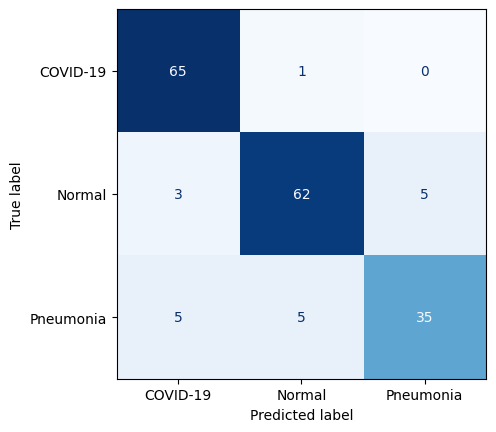

In [187]:
param_grid = {
    'kernel': ['rbf'],
    # Broader range of C values to find optimal regularization
    'C': [1000, 3000, 5000, 8000, 10000],
    # Finer gamma values
    'gamma': [0.001, 0.0015, 0.002, 0.003, 0.005],
    # More aggressive class weights for Pneumonia
    'class_weight': ['balanced',{0:1, 1:1, 2:1.5}, {0:1, 1:1, 2:2}, {0:1, 1:1, 2:2.5}]
}

svm_gridsearch = GridSearchCV(
    SVC(probability=True),
    param_grid,
    cv=5,
    scoring='f1_macro',  # Could also try 'recall_macro' to focus on recall
    n_jobs=-1,
    verbose=1
)

svm_gridsearch.fit(X= X_train, y= y_train)
best_params = svm_gridsearch.best_params_
print(f"Best parameters: {best_params}")
best_svm = SVC(**best_params)
best_svm.fit(X_train, y_train)
y_pred = best_svm.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

# KNN model on edited data

In [190]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    glcm_df.drop(columns=['image_id', 'label'], axis=1),
                                                    glcm_df['label'],
                                                    test_size=0.3,
                                                    random_state=113,
                                                    stratify=glcm_df['label']
                                                    )

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.82      0.87        66
           1       0.82      0.91      0.86        70
           2       0.69      0.69      0.69        45

    accuracy                           0.82       181
   macro avg       0.81      0.81      0.81       181
weighted avg       0.83      0.82      0.82       181

Confusion Matrix:


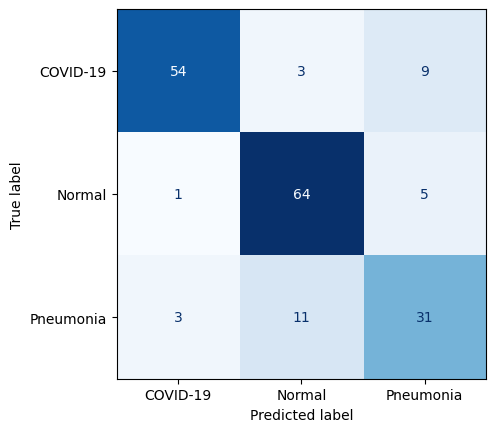

In [191]:
from sklearn.neighbors import KNeighborsClassifier


# Basic KNN model with default parameters
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# Predict on test set
y_pred = knn.predict(X_test)

# Evaluate performance
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
Best cross-validation score: 0.7837

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.79      0.85        66
           1       0.84      0.89      0.86        70
           2       0.67      0.76      0.71        45

    accuracy                           0.82       181
   macro avg       0.81      0.81      0.81       181
weighted avg       0.83      0.82      0.82       181


Confusion Matrix:


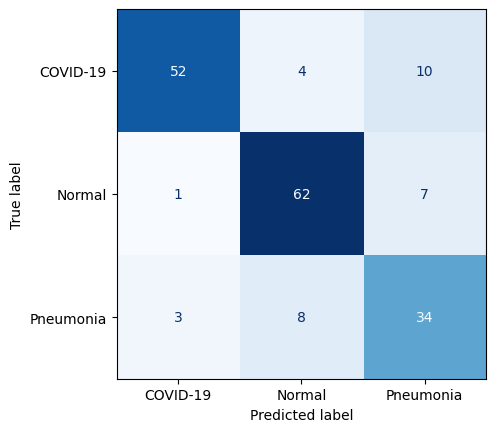

In [197]:

param_grid = {
    'n_neighbors': [3,4, 5,6, 7,8, 9,10, 11,12, 13,14, 15, 16, 17, 18, 19, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='f1_macro',  # Using the same scoring as your SVM
    n_jobs=-1,
    verbose=1
)


knn_grid.fit(X_train, y_train)

# Get best parameters and score
print(f"Best parameters: {knn_grid.best_params_}")
print(f"Best cross-validation score: {knn_grid.best_score_:.4f}")

# Create model with best parameters
best_knn = KNeighborsClassifier(**knn_grid.best_params_)
best_knn.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_knn.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()

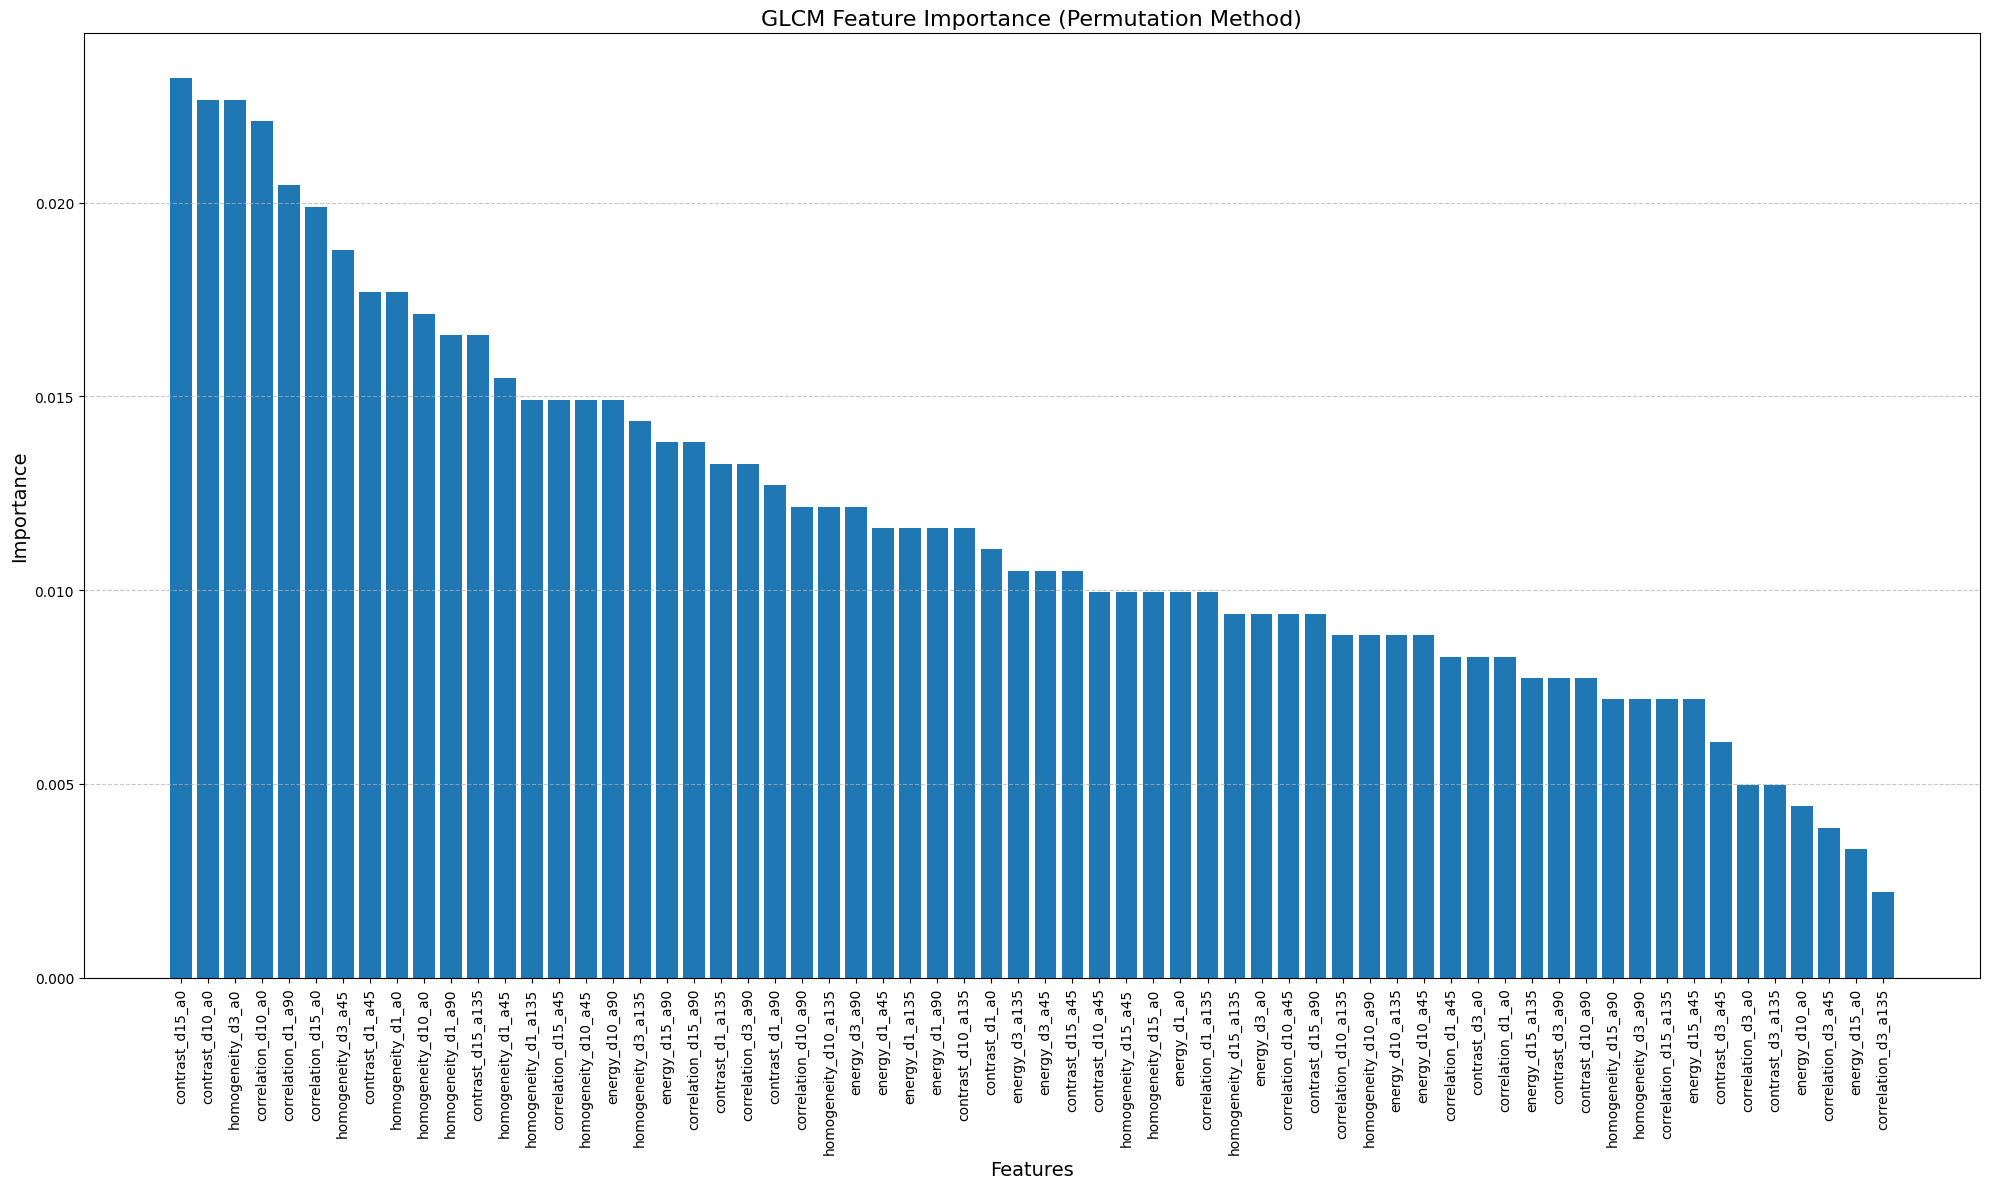

In [198]:
# permutation importance
result = permutation_importance(best_knn, X_test, y_test, n_repeats=10, random_state=42)
perm_importances = result.importances_mean

# Extract feature names from df
feature_names = glcm_df.drop(columns=['image_id', 'label']).columns.tolist()

# Sort features by importance
perm_indices = np.argsort(perm_importances)[::-1]

# Plot ALL features
plt.figure(figsize=(20, 12))  # Larger figure for 48 features
plt.title("GLCM Feature Importance (Permutation Method)", fontsize=16)
plt.bar(range(len(perm_importances)), perm_importances[perm_indices], align="center")
plt.xticks(range(len(perm_importances)), [feature_names[i] for i in perm_indices], rotation=90, fontsize=10)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.show()

In [204]:
best_features = [feature_names[i] for i in perm_indices[:10]]
print(f"Best features: {best_features}")

Best features: ['contrast_d15_a0', 'contrast_d10_a0', 'homogeneity_d3_a0', 'correlation_d10_a0', 'correlation_d1_a90', 'correlation_d15_a0', 'homogeneity_d3_a45', 'contrast_d1_a45', 'homogeneity_d1_a0', 'homogeneity_d10_a0']


In [205]:
best_df = glcm_df[best_features]
best_df['label'] = glcm_df['label']
best_df['image_id'] = glcm_df['image_id']
best_df.head()

/var/folders/00/q09lmhs50djb7w24dm71zgpw0000gn/T/ipykernel_2214/135778501.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['label'] = glcm_df['label']
/var/folders/00/q09lmhs50djb7w24dm71zgpw0000gn/T/ipykernel_2214/135778501.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  best_df['image_id'] = glcm_df['image_id']


,contrast_d15_a0,contrast_d10_a0,homogeneity_d3_a0,correlation_d10_a0,correlation_d1_a90,correlation_d15_a0,homogeneity_d3_a45,contrast_d1_a45,homogeneity_d1_a0,homogeneity_d10_a0,label,image_id
0,273.035647,179.145971,0.409178,0.968469,0.998589,0.951527,0.418722,34.367676,0.603734,0.250820,0,01E392EE-69F9-4E33-BFCE-E5C968654078
1,361.625291,221.431220,0.278448,0.956295,0.997832,0.928503,0.270817,17.888810,0.473969,0.151842,0,03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C
2,831.557313,613.518617,0.104002,0.776911,0.957428,0.697461,0.111584,177.743839,0.133215,0.063338,0,1-s2.0-S0140673620303706-fx1_lrg
3,718.562712,387.131797,0.269397,0.963705,0.998676,0.931983,0.285576,25.079182,0.430614,0.153448,0,1-s2.0-S0929664620300449-gr2_lrg-a
4,552.889269,370.930361,0.285447,0.947481,0.998086,0.921279,0.294095,95.797894,0.392329,0.192173,0,1-s2.0-S0929664620300449-gr2_lrg-b


In [206]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    best_df.drop(columns=['image_id', 'label'], axis=1),
                                                    best_df['label'],
                                                    test_size=0.3,
                                                    random_state=113,
                                                    stratify=best_df['label']
                                                    )
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Best parameters: {'algorithm': 'auto', 'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
Best cross-validation score: 0.7848

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.82      0.88        66
           1       0.81      0.86      0.83        70
           2       0.64      0.71      0.67        45

    accuracy                           0.81       181
   macro avg       0.80      0.80      0.80       181
weighted avg       0.82      0.81      0.81       181


Confusion Matrix:


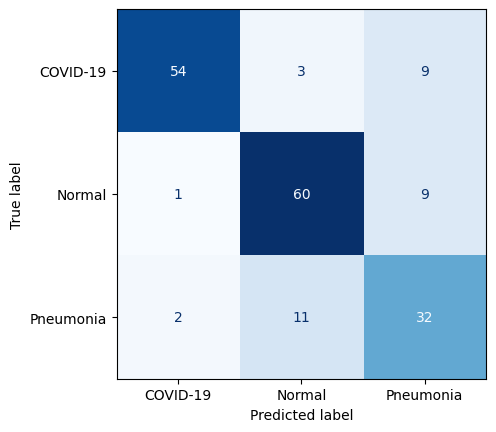

In [207]:

param_grid = {
    'n_neighbors': [3,4, 5,6, 7,8, 9,10, 11,12, 13,14, 15, 16, 17, 18, 19, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

knn_grid = GridSearchCV(
    KNeighborsClassifier(),
    param_grid,
    cv=5,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)


knn_grid.fit(X_train, y_train)

# Get best parameters and score
print(f"Best parameters: {knn_grid.best_params_}")
print(f"Best cross-validation score: {knn_grid.best_score_:.4f}")

# Create model with best parameters
best_knn = KNeighborsClassifier(**knn_grid.best_params_)
best_knn.fit(X_train, y_train)

# Evaluate on test set
y_pred = best_knn.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
ConfusionMatrixDisplay.from_predictions(y_true= y_test,
                                        y_pred= y_pred,
                                        display_labels=label_map.values(),
                                        cmap=plt.cm.Blues,
                                        colorbar=False)
plt.show()